In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.cluster import KMeans
from scipy.stats import zscore
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("renttherunway.csv")
df.head()

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192476 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192197 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

In [5]:
## Check duplicated records in the dataset
len(df[df.duplicated()])

0

In [8]:
## dropping redundant columns
df = df.drop(columns=['Unnamed: 0','user_id','item_id','review_text','review_date'],axis=1)

In [11]:
##removinf string data from weight colomn and convert to float
df['weight'] = df['weight'].apply(lambda x: float(x.replace('lbs', '')) if isinstance(x, str) else x)

In [12]:
# Check unique categories in the 'rented for' column
unique_categories = df['rented for'].unique()
print("Unique categories in 'rented for' column:", unique_categories)

# Group 'party: cocktail' category with 'party'
df['rented for'] = df['rented for'].replace('party: cocktail', 'party')




Unique categories in 'rented for' column: ['vacation' 'other' 'party' 'formal affair' 'wedding' 'date' 'everyday'
 'work' nan 'party: cocktail']


In [14]:
# Convert height from feet to inches and change datatype to float
def convert_height(height):
    if isinstance(height, str):
        feet, inches = height.split("'")
        total_inches = float(feet) * 12 + float(inches[:-1])
        return total_inches
    else:
        return height

df['height'] = df['height'].apply(convert_height)

# Display the modified DataFrame
df


,fit,bust size,weight,rating,rented for,body type,review_summary,category,height,size,age
0,fit,34d,137.0,10.0,vacation,hourglass,So many compliments!,romper,68.0,14,28.0
1,fit,34b,132.0,10.0,other,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0
2,fit,NaN,NaN,10.0,party,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0
3,fit,34c,135.0,8.0,formal affair,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0
4,fit,34b,145.0,10.0,wedding,athletic,Was in love with this dress !!!,gown,69.0,12,27.0
...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,34dd,140.0,10.0,work,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69.0,8,42.0
192540,fit,32c,100.0,10.0,work,petite,LOVE it!,dress,61.0,4,29.0
192541,fit,36a,135.0,6.0,everyday,straight & narrow,"Loud patterning, flattering fit",dress,68.0,8,31.0
192542,fit,36c,165.0,10.0,wedding,pear,loved this dress it was comfortable and photog...,dress,66.0,16,31.0


In [15]:
## lets check missing values in the dataset
df.isnull().sum()/len(df)*100

fit                0.000000
bust size          9.561970
weight            15.571506
rating             0.042588
rented for         0.005194
body type          7.601899
review_summary     0.180219
category           0.000000
height             0.351608
size               0.000000
age                0.498587
dtype: float64

In [37]:
# Check for missing values in each column
missing_value=df.isnull().sum()
print(missing_value)


# Impute missing values with appropriate methods
# For 'bust size','rented for' and 'review_summary' we can fill missing values with the mode
df['bust size'].fillna(df['bust size'].mode()[0], inplace=True)
df['rented for'].fillna(df['rented for'].mode()[0], inplace=True)
df['review_summary'].fillna(df['review_summary'].mode()[0], inplace=True)

# For 'body type', 'weight', and 'age', we can fill missing values with the mean
df['body type'].fillna(df['body type'].mode()[0], inplace=True)
df['weight'].fillna(df['weight'].mean(), inplace=True)
df['age'].fillna(df['age'].mean(), inplace=True)
df['rating'].fillna(df['rating'].mean(), inplace=True)
df['height'].fillna(df['height'].mean(), inplace=True)





fit                 0
bust size           0
weight              0
rating              0
rented for          0
body type           0
review_summary      0
category            0
height            677
size                0
age                 0
dtype: int64


In [38]:
df.isnull().sum()

fit               0
bust size         0
weight            0
rating            0
rented for        0
body type         0
review_summary    0
category          0
height            0
size              0
age               0
dtype: int64

In [39]:
# Statistical summary for numerical columns
numerical_summary = df.describe()
print("Statistical summary for numerical columns:")
print(numerical_summary)

# Statistical summary for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_summary = {}
for col in categorical_columns:
    categorical_summary[col] = df[col].value_counts()

print("\nStatistical summary for categorical columns:")
for col, summary in categorical_summary.items():
    print(f"\n{col}:\n{summary}")


Statistical summary for numerical columns:
              weight         rating         height           size  \
count  192544.000000  192544.000000  192544.000000  192544.000000   
mean      137.391709       9.092371      65.310621      12.245175   
std        20.122771       1.429740       2.658793       8.494877   
min        50.000000       2.000000      54.000000       0.000000   
25%       125.000000       8.000000      63.000000       8.000000   
50%       137.391709      10.000000      65.000000      12.000000   
75%       145.000000      10.000000      67.000000      16.000000   
max       300.000000      10.000000      78.000000      58.000000   

                 age  
count  192544.000000  
mean       33.871017  
std         8.037969  
min         0.000000  
25%        29.000000  
50%        32.000000  
75%        37.000000  
max       117.000000  

Statistical summary for categorical columns:

fit:
fit
fit      142058
small     25779
large     24707
Name: count, dtype: int6

In [ ]:
##For numerical columns (like 'weight', 'rating', 'size', 'age'), we will get statistics such as count, mean, standard deviation, minimum, quartiles, and maximum values.
##For categorical columns (like 'fit', 'bust size', 'rented for', 'body type', 'review_summary', 'category'), you'll get counts of unique values in each category.

In [40]:
#outliers in the column age
# Calculate the IQR
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

# Treat outliers by replacing them with the median age
median_age = df['age'].median()
df['age'] = np.where((df['age'] < lower_bound) | (df['age'] > upper_bound), median_age, df['age'])

# Display the modified DataFrame
print("Outliers in 'age' column:")
print(outliers)
print("\nModified DataFrame after treating outliers:")
print(df)


Outliers in 'age' column:
          fit bust size      weight  rating     rented for          body type  \
2         fit       34b  137.391709    10.0          party          hourglass   
7         fit      34d+  118.000000    10.0  formal affair          full bust   
31        fit       32c  122.000000    10.0        wedding  straight & narrow   
39        fit       32d  137.391709    10.0          party          hourglass   
56        fit       34d  128.000000    10.0          party              apple   
...       ...       ...         ...     ...            ...                ...   
192489    fit       32d  140.000000     8.0           work          hourglass   
192495    fit       40b  155.000000    10.0  formal affair          hourglass   
192504    fit       34b  170.000000     8.0       vacation          hourglass   
192517    fit       36d  137.391709    10.0          party          full bust   
192532  small       36c  150.000000    10.0        wedding          hourglass   

 

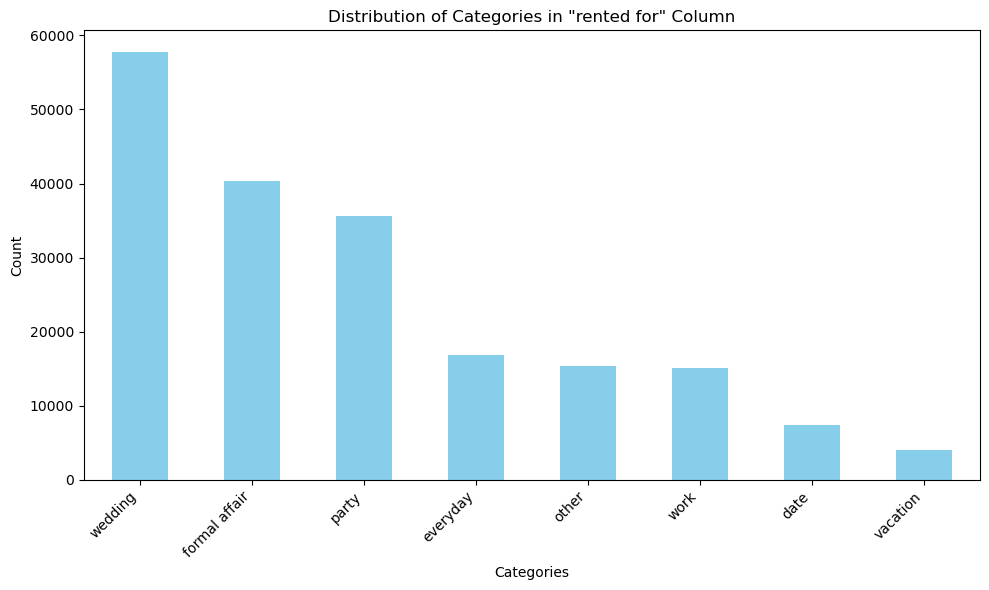

In [41]:
# Count the occurrences of each category in 'rented for'
rented_for_counts = df['rented for'].value_counts()

# Plotting the distribution
plt.figure(figsize=(10, 6))
rented_for_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories in "rented for" Column')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [74]:
dfc = df.copy()

In [43]:
# encode categorical variables in the dat set
## Label Encoding
columns=['fit', 'bust size', 'rented for', 'body type', 'review_summary', 'category']
lbl_encode = LabelEncoder()
for i in columns:
    df[i]=df[[i]].apply(lbl_encode.fit_transform)


In [82]:
## Standardization
df1 = df.copy()
scaled_features = StandardScaler().fit_transform(df1.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)

In [52]:
#Principal Component Analysis and Clustering
## step1: Calculate the covariance matrix.
cov_matrix = np.cov(scaled_features.T)
cov_matrix

array([[ 1.00000519e+00,  9.05525666e-03,  1.34138344e-02,
        -2.45017128e-01,  8.35378787e-03, -7.61016810e-03,
         4.01169992e-03,  3.35892077e-04,  1.56520435e-04,
         6.54006939e-02, -1.07655522e-03],
       [ 9.05525666e-03,  1.00000519e+00,  5.74163260e-01,
        -2.09463072e-02, -2.07814670e-03, -2.15702411e-01,
        -4.36240476e-03, -1.09647683e-02,  1.47029967e-01,
         6.27115858e-01,  1.40978490e-01],
       [ 1.34138344e-02,  5.74163260e-01,  1.00000519e+00,
        -2.06828900e-02,  9.91868005e-03, -2.35893510e-01,
        -3.75202422e-03, -1.48283310e-02,  3.50844864e-01,
         7.32740552e-01,  6.52415533e-02],
       [-2.45017128e-01, -2.09463072e-02, -2.06828900e-02,
         1.00000519e+00,  1.28842617e-02,  4.73487321e-03,
        -4.68475515e-03, -2.36044968e-02,  1.74189843e-03,
        -3.67259761e-02, -4.87897307e-02],
       [ 8.35378787e-03, -2.07814670e-03,  9.91868005e-03,
         1.28842617e-02,  1.00000519e+00, -9.08626233e-03,
  

In [46]:
## step2: Calculate the eigen values and eigen vectors.
eig_vals, eig_vectors = np.linalg.eig(cov_matrix)
print('eigein vals:','\n',eig_vals)
print('\n')
print('eigein vectors','\n',eig_vectors)

eigein vals: 
 [2.55271821 0.2493552  0.41689084 1.25042885 0.74894215 1.07289677
 0.85566675 1.02672294 0.89526345 0.98698412 0.94418786]


eigein vectors 
 [[ 3.76184804e-02  5.14522517e-02 -3.73308642e-02  6.84377059e-01
   6.85754118e-01 -1.70366305e-01 -8.69072586e-02  1.25592131e-01
   1.45661913e-02 -5.67841638e-02 -1.12117974e-02]
 [ 4.95796620e-01  9.79790352e-02 -7.89577175e-01 -1.93022959e-02
  -4.77133968e-02  3.50632945e-02 -2.19122650e-01 -1.30807826e-01
   1.91966507e-01  1.21806672e-01 -2.14871115e-02]
 [ 5.47274449e-01  6.78930777e-01  4.47668676e-01 -5.03539564e-02
  -3.43400951e-02 -3.63899256e-02  1.45539887e-02  8.29078931e-02
   1.62300028e-01 -2.47205141e-02 -7.71388587e-03]
 [-3.68993717e-02  6.47925001e-03  1.91660390e-04 -7.01141824e-01
   7.01808270e-01  2.96011767e-02 -9.19875009e-02 -1.58471278e-02
   5.69006980e-02  3.33610688e-02  2.28473592e-02]
 [ 1.89413370e-03 -5.52961487e-03 -1.80956703e-02 -4.25877464e-02
  -3.11161481e-02 -6.46355668e-01  1.9240655

In [47]:
## step3: Scree plot.
total = sum(eig_vals)
var_exp = [(i/total)*100 for i in sorted(eig_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Explained Variance: ',var_exp)
print('Cummulative Variance Explained: ',cum_var_exp)

Explained Variance:  [23.20640865002498, 11.367475957344428, 9.753556344135458, 9.333796450974827, 8.9725362769191, 8.5834813939785, 8.138716328443559, 7.77874822672949, 6.808529641310591, 3.7898970685392572, 2.2668536615998174]
Cummulative Variance Explained:  [ 23.20640865  34.57388461  44.32744095  53.6612374   62.63377368
  71.21725507  79.3559714   87.13471963  93.94324927  97.73314634
 100.        ]


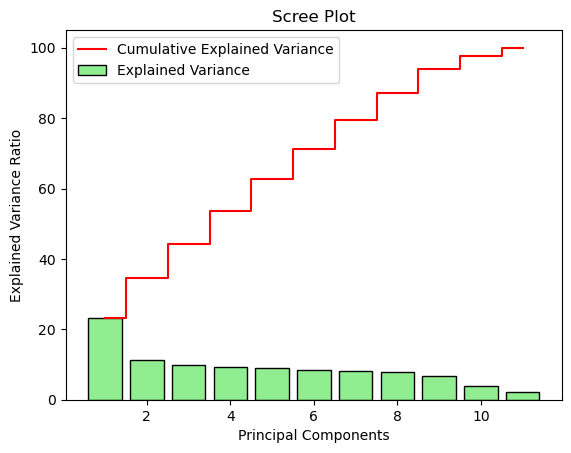

In [51]:
## Scree plot.
plt.bar(range(1, len(var_exp) + 1), var_exp, align='center', color='lightgreen', edgecolor='black', label='Explained Variance')
plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.show()


In [53]:
## Using the dimensions obtainted from the PCA to apply clustering.(i.e, 8)
pca = PCA(n_components=8)

pca_df = pd.DataFrame(pca.fit_transform(scaled_features_df),columns=['PC1','PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8'])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.212454,-0.864808,0.633316,1.272372,0.099672,1.519126,0.324829,-0.548641
1,-0.646435,-0.699158,0.325722,-0.640103,0.141335,-0.922737,1.369800,-1.060921
2,-0.834308,-0.652872,1.124856,-0.043097,0.268175,1.251380,0.181027,0.275929
3,-0.537084,0.173903,0.153056,-0.731635,0.875174,-1.228976,0.249040,-0.158503
4,0.629427,-1.174479,-0.841447,1.822513,-0.700434,0.763344,-1.144127,-0.528615


In [54]:
## finding optimal K value by KMeans clustering using Elbow plot.
cluster_errors = []
cluster_range = range(2,15)
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,random_state=100)
    clusters.fit(pca_df)
    cluster_errors.append(clusters.inertia_)

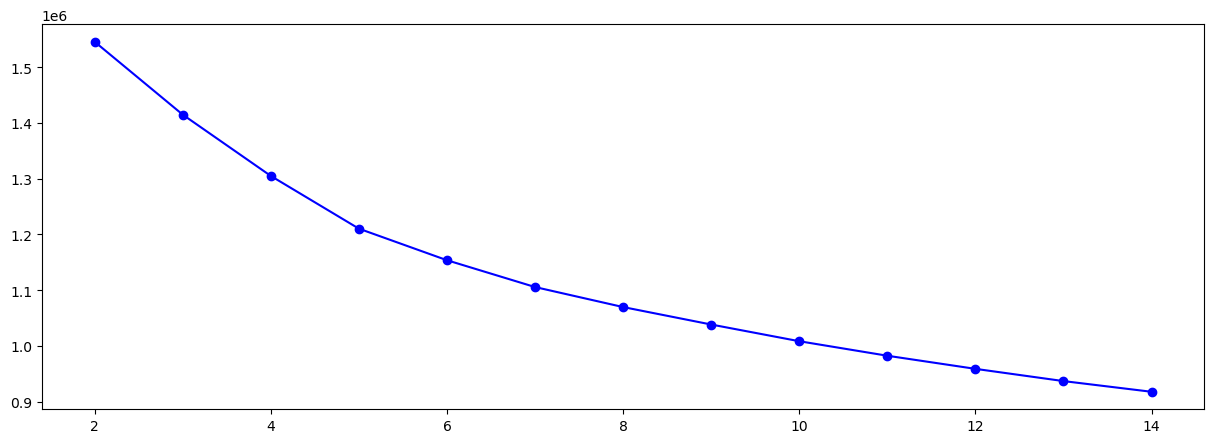

In [55]:
## creataing a dataframe of number of clusters and cluster errors.
cluster_df = pd.DataFrame({'num_clusters':cluster_range,'cluster_errors':cluster_errors})

## Elbow plot.
plt.figure(figsize=[15,5])
plt.plot(cluster_df['num_clusters'],cluster_df['cluster_errors'],marker='o',color='b')
plt.show()

In [56]:
## Applying KMeans clustering for the optimal number of clusters obtained above.
kmeans = KMeans(n_clusters=3, random_state=100)
kmeans.fit(pca_df)

KMeans(n_clusters=3, random_state=100)

In [57]:
## creating a dataframe of the labels.
label = pd.DataFrame(kmeans.labels_,columns=['Label'])

In [58]:
## joining the label dataframe to the pca_df dataframe.
kmeans_df = pca_df.join(label)
kmeans_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Label
0,0.212454,-0.864808,0.633316,1.272372,0.099672,1.519126,0.324829,-0.548641,0
1,-0.646435,-0.699158,0.325722,-0.640103,0.141335,-0.922737,1.369800,-1.060921,0
2,-0.834308,-0.652872,1.124856,-0.043097,0.268175,1.251380,0.181027,0.275929,0
3,-0.537084,0.173903,0.153056,-0.731635,0.875174,-1.228976,0.249040,-0.158503,0
4,0.629427,-1.174479,-0.841447,1.822513,-0.700434,0.763344,-1.144127,-0.528615,1


In [59]:
kmeans_df['Label'].value_counts()

Label
0    97462
1    58238
2    36844
Name: count, dtype: int64

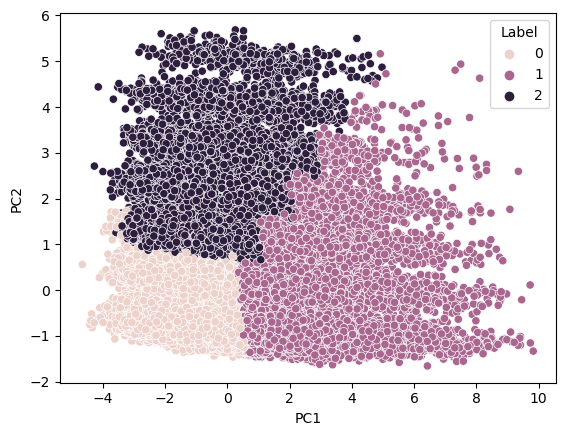

In [60]:
## visualizing the clusters formed 
sns.scatterplot(x=kmeans_df['PC1'], y=kmeans_df['PC2'], hue=kmeans_df['Label'])
plt.show()

In [ ]:
##Apply Agglomerative clustering and segment the data. (You may use original data or PCA transformed data) (8)

In [88]:
##Sampling the scaled data to reduce the size
sample_scaled_features = scaled_features[np.random.choice(scaled_features.shape[0], 1000, replace=False)]

sample_scaled_features_df = scaled_features_df.sample(n=1000, random_state=42)

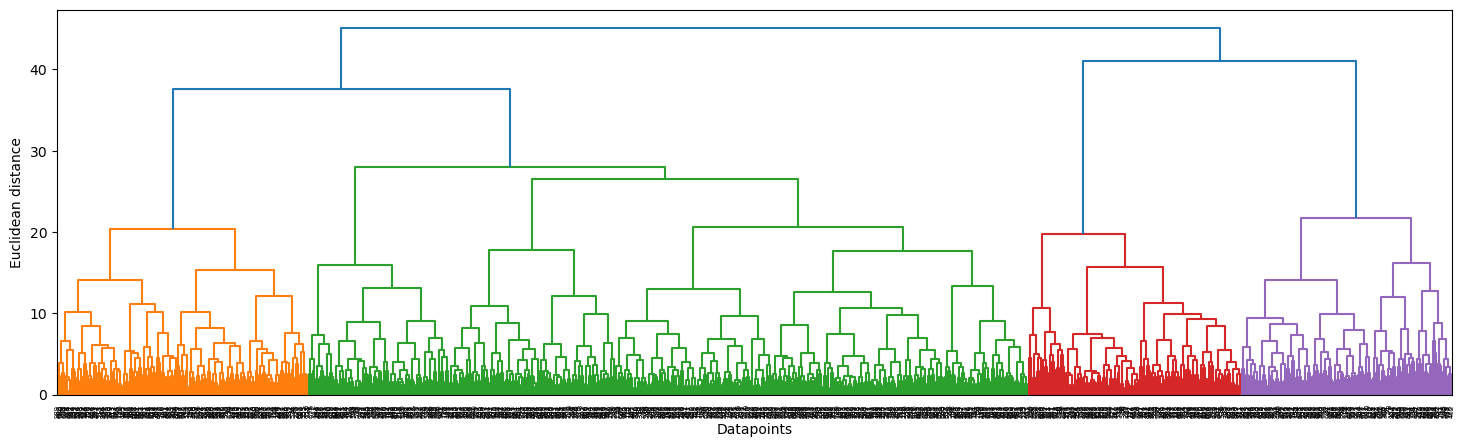

In [89]:
plt.figure(figsize=[18, 5])
sample_data = df.sample(n=1000, random_state=42)
merg = linkage(sample_scaled_features, method='ward')  
dendrogram(merg, leaf_rotation=90,)
plt.xlabel('Datapoints')
plt.ylabel('Euclidean distance')
plt.show()


In [90]:
from sklearn.metrics import silhouette_score

In [91]:
for i in range(2,15):
    hier = AgglomerativeClustering(n_clusters=i)
    hier = hier.fit(sample_scaled_features_df)
    labels = hier.fit_predict(sample_scaled_features_df)
    print(i,silhouette_score(sample_scaled_features_df,labels))

2 0.06758830176411255
3 0.07130515928564819
4 0.06874748587127849
5 0.067507235428799
6 0.08041758783694072
7 0.07232269598538435
8 0.07588983920255049
9 0.06563986919719028
10 0.07110345875041901
11 0.06548729351349863
12 0.06546694011063656
13 0.06512084332455292
14 0.060864608261789625


In [93]:
## Building hierarchical clustering model using the optimal clusters as 3 using original data
hie_cluster = AgglomerativeClustering(n_clusters=3,
                                     linkage='ward')
hie_cluster_model = hie_cluster.fit(sample_scaled_features_df)

In [94]:
## Creating a dataframe of the labels
df_label1 = pd.DataFrame(hie_cluster_model.labels_,columns=['Labels'])
df_label1.head(5)

,Labels
0,0
1,2
2,0
3,1
4,1


In [95]:
## joining the label dataframe with unscaled initial cleaned dataframe.(dfc)

df_hier = dfc.join(df_label1)
df_hier.head()

,fit,bust size,weight,rating,rented for,body type,review_summary,category,height,size,age,Labels
0,0,39,137.000000,10.0,5,3,109621,44,68.0,14,28.0,0.0
1,0,37,132.000000,10.0,3,6,59681,20,66.0,12,36.0,2.0
2,0,37,137.391709,10.0,4,3,74243,45,64.0,4,32.0,0.0
3,0,38,135.000000,8.0,2,4,28142,16,65.0,8,34.0,1.0
4,0,37,145.000000,10.0,6,1,140371,20,69.0,12,27.0,1.0


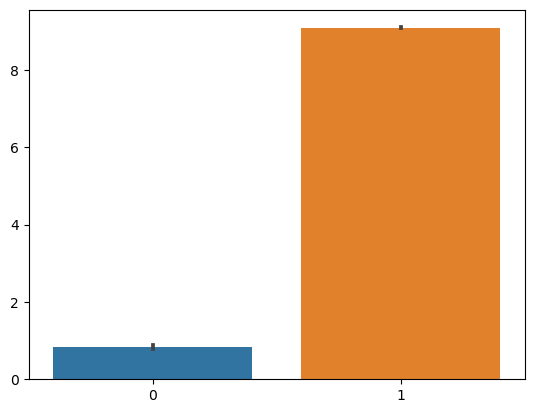

In [99]:
import seaborn as sns
sns.barplot([df_hier['Labels'],df_hier['rating']])
plt.show()

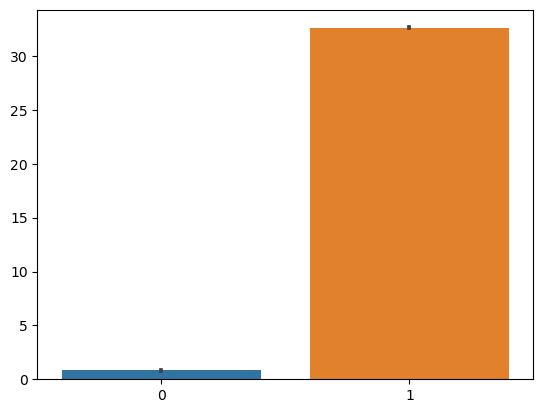

In [100]:
import seaborn as sns
sns.barplot([df_hier['Labels'],df_hier['age']])
plt.show()

In [101]:
####Observations
###Rating by Fit:
#The average rating for the 'fit' category seems to be consistent across different fit types (0, 1, 2), with most items receiving a high rating of 8 or above.There is no significant difference in the average rating between the different fit categories.

#Age by Fit:

#The average age for the 'fit' category varies slightly across different fit types (0, 1, 2), but the differences are not very pronounced.Fit type 2 (represented as '1.0' in the data) appears to have the highest average age, followed by fit type 1 ('0.0') and then fit type 0 ('2.0').